In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
import torch.nn as nn

In [2]:
from scripts.networkArchitecture import network
from scripts.create_dataset import get_train_test_split

In [3]:
import matplotlib

#Setting the plotting parameters
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
matplotlib.rcParams['font.size']= 20
matplotlib.rcParams['font.family']= 'ptm' #'Times New Roman

In [4]:
def get_predicted(model,X,timesteps_test):
    res = X.clone()
    for _ in range(timesteps_test):
        res = model(res)
    return res[:,0].detach().cpu().numpy()
      
def get_true(Y,k):
    return Y[:,k-1].detach().cpu().numpy()

In [5]:
class relu_squared(nn.Module):
    def __init__(self,):
        super().__init__()
    def forward(self,x):
        return torch.relu(x)**2

In [6]:
class network(nn.Module):
    def __init__(self,is_linear=False,zero_sum_first=False,bias=False,pde_name='linadv',kernel_size=5,nlayers=3,dt=0.1,preserve_norm=False):
        super().__init__()
        
        self.dt = dt
        self.nlayers = nlayers
        
        self.is_linear = is_linear
        self.preserve_norm = preserve_norm
        self.zero_sum = zero_sum_first
        self.pde_name = pde_name
        
        self.correct_vec_field = preserve_norm #we do so only if we want to preserve the norm
        
        relu2 = relu_squared()
        
        if kernel_size==5:
            pad = 2
        elif kernel_size==7:
            pad = 3
        else:
            pad = 1
        
        self.pad = pad
        self.circular_padding = lambda x : F.pad(x, (self.pad,self.pad,self.pad, self.pad), mode='circular')
        pad_mode = 'circular'
        
        if pde_name=="heat":
            self.F = nn.Sequential(
                    nn.Conv2d(1,2,kernel_size=kernel_size,padding=pad,padding_mode=pad_mode,bias=True,dtype=dtype),
                    nn.ReLU(),
                    nn.Conv2d(2,1,kernel_size=kernel_size,padding=pad,padding_mode=pad_mode,bias=False,dtype=dtype)
                )
            #self.F[-1].weight.data = torch.tensor([1.,-1.]).reshape(*self.F[-1].weight.data.shape)
        elif pde_name=="fisher":
            '''self.F = nn.Sequential(
                    nn.Conv2d(1,12,kernel_size=kernel_size,padding=pad,padding_mode=pad_mode,bias=True,dtype=dtype),
                    relu2,
                    nn.Conv2d(12,1,kernel_size=kernel_size,padding=pad,padding_mode=pad_mode,bias=False,dtype=dtype)
                ) # previous tests'''
            self.F = nn.Sequential(
                    nn.Conv2d(1,10,kernel_size=kernel_size,padding=pad,padding_mode=pad_mode,bias=True,dtype=dtype),
                    relu2,
                    nn.Conv2d(10,1,kernel_size=kernel_size,padding=pad,padding_mode=pad_mode,bias=True,dtype=dtype)
                )
        else: 
            self.F = nn.Sequential(
                nn.Conv2d(1,2,kernel_size=kernel_size,padding=pad,padding_mode=pad_mode,bias=True,dtype=dtype),
                nn.ReLU(),
                nn.Conv2d(2,1,kernel_size=kernel_size,padding=pad,padding_mode=pad_mode,bias=False,dtype=dtype)
            )
    
    def vecField(self,U):
        FF = self.F(U)    
        if self.pde_name=="linadv":
            if self.correct_vec_field:
                dot_x_f = (U*FF).reshape(len(U),-1).sum(dim=1).reshape(-1,1,1,1)
                dot_x_x = (U*U).reshape(len(U),-1).sum(dim=1).reshape(-1,1,1,1)
                return FF - U * dot_x_f / dot_x_x
            else:
                return FF
        else:
            return FF
    
    def forward(self,U,no_initial=[]):        
        if self.preserve_norm:
            if len(no_initial)==0:
                no_initial = torch.linalg.norm(U.reshape(len(U),-1),ord=2,dim=1)
        if self.zero_sum:
            self.F[0].weight.data -= torch.mean(self.F[0].weight.data,dim=(2,3)).view(-1,1,1,1)
        for _ in range(self.nlayers):
            U = U + self.dt/self.nlayers * self.vecField(U)
            if self.preserve_norm:
                U = U * no_initial.view(-1,1,1,1) / torch.linalg.norm(U.reshape(len(U),-1),ord=2,dim=1).view(-1,1,1,1)
        return U

## Models with $5\times 5$ convolution

In [7]:
pde_name = 'fisher'

timesteps = 5

#Create the model

nlayers = 3
bias = True
dim = 100
lr = 5e-3
epochs = 300
batch_size = 32

dim = 100 #Size of the input matrices (100x100)
alpha = .01 #Diffusivity constant
xx = np.linspace(0,1,dim+1) #Spatial discretization of [0,1]
dx = xx[1]-xx[0] #Spatial step

kernel_size = 5
weight_decay = 0.
is_linear = False
is_cyclic = True
#is_noise_list = [True,False]
is_noise = False
zero_sum = False
preserve_norm = False

dtype = torch.float32
np_dtype = np.float32

dt = 0.1 if pde_name=='linadv' else 0.24 * dx**2 / alpha #Temporal step

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
model_8 = network(pde_name=pde_name,
                kernel_size=kernel_size,
                nlayers=nlayers,
                dt=dt,
                preserve_norm=preserve_norm)

model_8.load_state_dict(torch.load("trainedMultiResolutionFisher/trained_model_8.pt",map_location=device))

model_4 = network(pde_name=pde_name,
                kernel_size=kernel_size,
                nlayers=nlayers,
                dt=dt/2,
                preserve_norm=preserve_norm)

model_4.load_state_dict(torch.load("trainedMultiResolutionFisher/trained_model_4.pt",map_location=device))

model_2 = network(pde_name=pde_name,
                kernel_size=kernel_size,
                nlayers=nlayers,
                dt=dt/4,
                preserve_norm=preserve_norm)

model_2.load_state_dict(torch.load("trainedMultiResolutionFisher/trained_model_2.pt",map_location=device))

model_1 = network(pde_name=pde_name,
                kernel_size=kernel_size,
                nlayers=nlayers,
                dt=dt/8,
                preserve_norm=preserve_norm)

model_1.load_state_dict(torch.load("trainedMultiResolutionFisher/trained_model_1.pt",map_location=device))

<All keys matched successfully>

In [9]:
trainset, testset = get_train_test_split(pde_name=pde_name,timesteps=timesteps,device=device,dtype=dtype)
testloader = torch.utils.data.DataLoader(testset,batch_size=30,shuffle=True,num_workers=0)

X,Y = next(iter(testloader))

In [10]:
model_8.eval();
model_4.eval();
model_2.eval();
model_1.eval();

#### Comparison based on the same final time

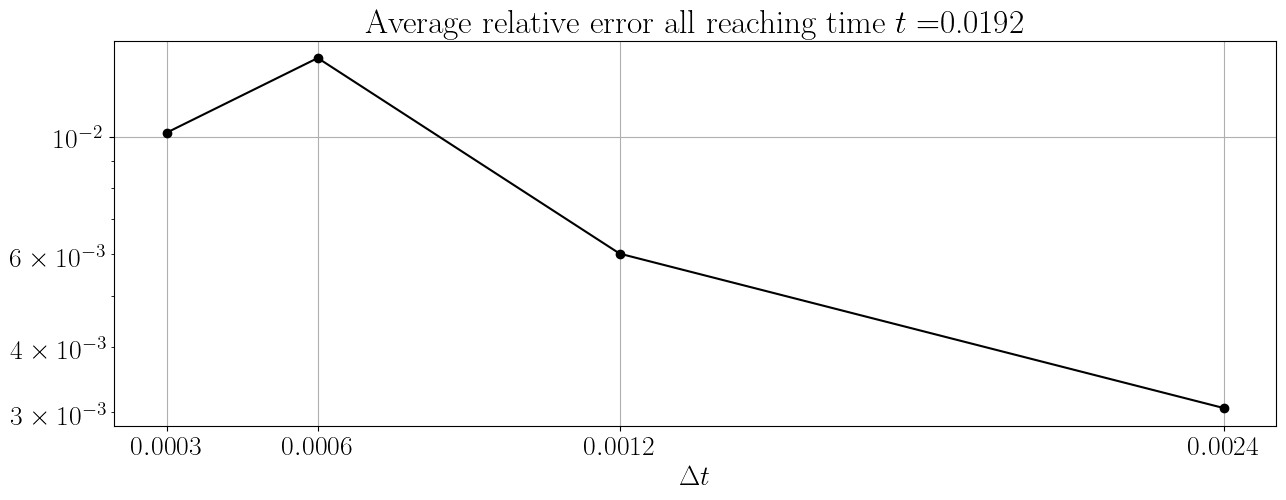

In [11]:
ntime = 8
XX = X.clone()
pred_8 = get_predicted(model_8,X,timesteps_test=ntime)
pred_4 = get_predicted(model_4,X,timesteps_test=2*ntime)
pred_2 = get_predicted(model_2,X,timesteps_test=4*ntime)
pred_1 = get_predicted(model_1,X,timesteps_test=8*ntime)

true = get_true(Y,ntime)

def computeError(pred,ref):
    num = np.linalg.norm((pred-ref),ord='fro',axis=(1,2))
    den = np.linalg.norm(ref,ord='fro',axis=(1,2))
    return np.mean(num/den)


error_1 = computeError(pred_1,true)
error_2 = computeError(pred_2,true)
error_4 = computeError(pred_4,true)
error_8 = computeError(pred_8,true)

fig = plt.figure(figsize=(15,5))
plt.semilogy([dt/8,dt/4,dt/2,dt],[error_1,error_2,error_4,error_8],'k-o')
plt.xticks([dt/8,dt/4,dt/2,dt])
plt.xlabel(r"$\Delta t$")
#plt.ylabel(r"$\frac{\|\mathcal{N}^N(U_n^0)-U_n^N\|_F}{\|U_n^N\|_F}$")
plt.title(fr"Average relative error all reaching time $t=${model_8.dt*ntime:.4f}")
plt.grid(True)

plt.savefig(f"{ntime}_coarse_steps.pdf",bbox_inches="tight")
plt.show();

#### Comparison based on performing the same number of steps

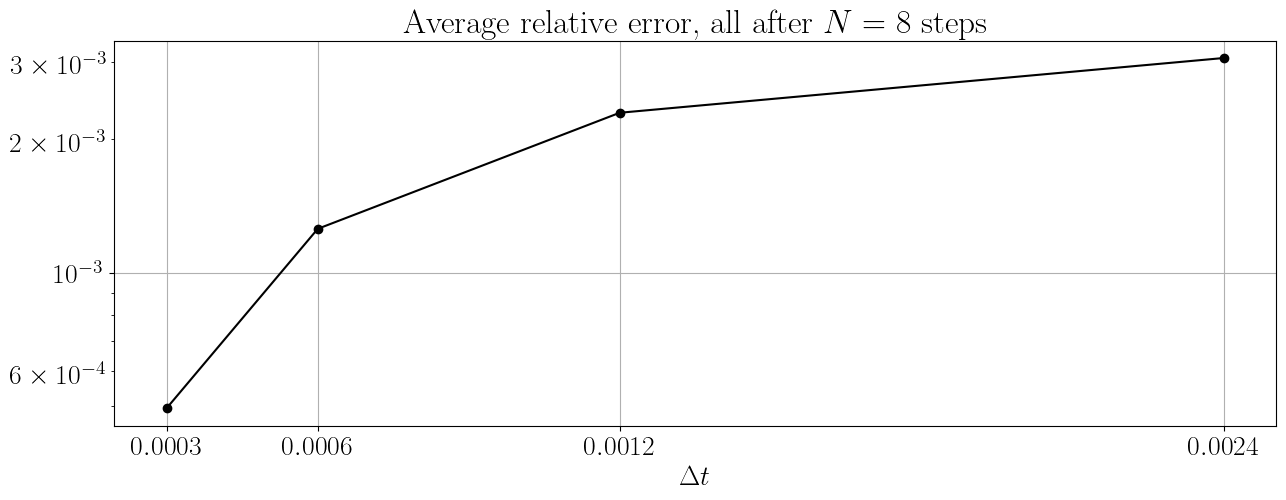

In [12]:
ntime = 8
XX = X.clone()
pred_8 = get_predicted(model_8,X,timesteps_test=ntime)
pred_4 = get_predicted(model_4,X,timesteps_test=ntime)
pred_2 = get_predicted(model_2,X,timesteps_test=ntime)
pred_1 = get_predicted(model_1,X,timesteps_test=ntime)

true_8 = get_true(Y,ntime)
true_4 = get_true(Y,ntime//2)
true_2 = get_true(Y,ntime//4)
true_1 = get_true(Y,ntime//8)

def computeError(pred,ref):
    num = np.linalg.norm((pred-ref),ord='fro',axis=(1,2))
    den = np.linalg.norm(ref,ord='fro',axis=(1,2))
    return np.mean(num/den)


error_1 = computeError(pred_1,true_1)
error_2 = computeError(pred_2,true_2)
error_4 = computeError(pred_4,true_4)
error_8 = computeError(pred_8,true_8)

fig = plt.figure(figsize=(15,5))

dts = np.array([dt/8,dt/4,dt/2,dt])

plt.semilogy(dts,[error_1,error_2,error_4,error_8],'k-o')
plt.xticks([dt/8,dt/4,dt/2,dt])

plt.xlabel(r"$\Delta t$")
plt.title(rf"Average relative error, all after $N=$ {ntime} steps")
plt.grid(True)
plt.savefig(f"all_with_{ntime}_steps.pdf",bbox_inches="tight")
plt.show();

In [13]:
8 * 0.24 * alpha * 0.01

0.00019199999999999998

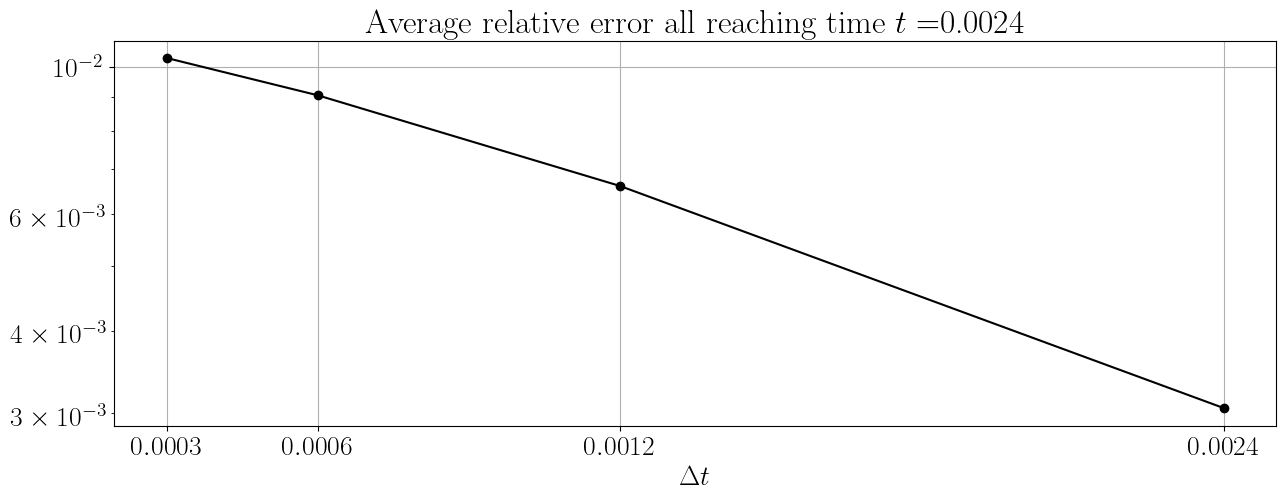

In [14]:
ntime = 8
XX = X.clone()
pred_8 = get_predicted(model_8,X,timesteps_test=ntime)
model_8.dt/=2
pred_4 = get_predicted(model_8,X,timesteps_test=2*ntime)
model_8.dt/=2
pred_2 = get_predicted(model_8,X,timesteps_test=4*ntime)
model_8.dt/=2
pred_1 = get_predicted(model_8,X,timesteps_test=8*ntime)

true = get_true(Y,ntime)

def computeError(pred,ref):
    num = np.linalg.norm((pred-ref),ord='fro',axis=(1,2))
    den = np.linalg.norm(ref,ord='fro',axis=(1,2))
    return np.mean(num/den)


error_1 = computeError(pred_1,true)
error_2 = computeError(pred_2,true)
error_4 = computeError(pred_4,true)
error_8 = computeError(pred_8,true)

fig = plt.figure(figsize=(15,5))
plt.semilogy([dt/8,dt/4,dt/2,dt],[error_1,error_2,error_4,error_8],'k-o')
plt.xticks([dt/8,dt/4,dt/2,dt])
plt.xlabel(r"$\Delta t$")
#plt.ylabel(r"$\frac{\|\mathcal{N}^N(U_n^0)-U_n^N\|_F}{\|U_n^N\|_F}$")
plt.title(fr"Average relative error all reaching time $t=${model_8.dt*ntime:.4f}")
plt.grid(True)

plt.savefig(f"change_dt_ntimes_{ntime}.pdf",bbox_inches="tight")
plt.show();